In [151]:
%matplotlib inline
%run 'notebook_utils.py'

import sys
import pprint
import cProfile

import matplotlib.pyplot as plt
import numpy             as np

import radical.utils     as ru
import radical.pilot     as rp
import radical.analytics as ra

from   radical.utils.profile import *
from   radical.pilot.states  import *

In [152]:
# Load wrangled data saved in .csv files for both synapse, microbenchmarks and gromacs.
sws_sessions = pd.read_csv('weak_scaling/sessions.csv', index_col=0)
sws_pilots = pd.read_csv('weak_scaling/pilots.csv', index_col=0)
sws_units = pd.read_csv('weak_scaling/units.csv', index_col=0)

# Load wrangled data saved in .csv files for both synapse, microbenchmarks and gromacs.
ssc_sessions = pd.read_csv('strong_scaling/sessions.csv', index_col=0)
ssc_pilots = pd.read_csv('strong_scaling/pilots.csv', index_col=0)
ssc_units = pd.read_csv('strong_scaling/units.csv', index_col=0)

In [153]:
print 'Synapse: Weak Scaling: Total number of successful runs: %s' % sws_sessions.shape[0]
print 'Synapse: Weak Scaling: Total number of pilots: %s' % sws_pilots.shape[0]
print 'Synapse: Weak Scaling: Total number of units: %s\n' % sws_units.shape[0]

print 'Synapse: Strong Scaling: Total number of successful runs: %s' % ssc_sessions.shape[0]
print 'Synapse: Strong Scaling: Total number of pilots: %s' % ssc_pilots.shape[0]
print 'Synapse: Strong Scaling: Total number of units: %s\n' % ssc_units.shape[0]

Synapse: Weak Scaling: Total number of successful runs: 6
Synapse: Weak Scaling: Total number of pilots: 6
Synapse: Weak Scaling: Total number of units: 7280

Synapse: Strong Scaling: Total number of successful runs: 6
Synapse: Strong Scaling: Total number of pilots: 6
Synapse: Strong Scaling: Total number of units: 12480



## Weak Scaling Results on Blue Waters

In [239]:
sws = sws_sessions[
    ['nunit','TTC','P_LRMS_QUEUING','U_AGENT_QUEUING','U_AGENT_SCHEDULING','U_AGENT_QUEUING_EXEC','U_AGENT_EXECUTING']
        ].groupby(['nunit']).aggregate(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std']})

sws.rename({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
sws.rename({'U_AGENT_QUEUING'     :'Agent queueing'}, axis='columns', inplace=True)
sws.rename({'U_AGENT_SCHEDULING'  :'Agent scheduling'}, axis='columns', inplace=True)
sws.rename({'U_AGENT_QUEUING_EXEC':'Agent queueing execution'}, axis='columns', inplace=True)
sws.rename({'U_AGENT_EXECUTING'   :'TTX'}, axis='columns', inplace=True)
sws.rename(index={i: '%s/%s' % (i/(65*4), i*8) for i in sws.index.get_values()}, inplace=True)
sws

TTQ               Agent queueing           Agent queueing execution                   TTX                      TTC               Agent scheduling          
               mean           std           mean       std                     mean       std        mean        std          mean           std             mean       std
nunit                                                                                                                                                                      
2/4160   4771.80865   6333.079485       1.225851  0.094961                23.733801  0.397250  2098.96080   1.663681  1.514526e+09  11492.408666         4.042499  0.160089
4/8320   8269.93625  10071.113359       2.914751  0.394491                53.580750  8.968733  2191.00365  54.757289  1.514581e+09  88980.189094        11.658749  0.055366
8/16640  5322.41770   4926.347608      10.942751  0.193111               133.541199  3.950323  2372.45005   0.624446  1.514527e+09  10871.981862        37.274151  0.453322

In [165]:
pws = sws_pilots[
    ['nunit','util_p_total','util_p_boot','util_p_term','util_p_uexec']
        ].groupby(['nunit']).aggregate(
                {'util_p_total'        : ['mean','std'],
                 'util_p_boot'         : ['mean','std'],
                 'util_p_term'         : ['mean','std'],
                 'util_p_uexec'        : ['mean','std']})


# 'orte_dvm_start'  is not captured in APRUN

pws.rename({'util_p_total'        :'p_total'}, axis='columns', inplace=True)
pws.rename({'util_p_boot'         :'p_bootstraps'}, axis='columns', inplace=True)
pws.rename({'util_p_term'         :'p_term'}, axis='columns', inplace=True)
pws.rename({'util_p_uexec'        :'p_uexec'}, axis='columns', inplace=True)

pws.rename(index={i: '%s/%s' % (i/(65*4), i*8) for i in pws.index.get_values()}, inplace=True)
pws

p_term               p_uexec                 p_total             p_bootstraps          
            mean       std        mean         std        mean         std         mean       std
nunit                                                                                            
2/4160   7.04425  1.073600  2142.10415    8.129253  2202.88370   13.166470     50.05820  2.592819
4/8320   7.77795  1.478914  2240.38870   62.842277  2293.69340   67.853684     41.67550  4.646682
8/16640  7.40790  1.818820  2533.82360  163.762819  2586.50705  162.062723     41.56825  3.813922

In [325]:
uws = sws_units[
    ['sid','AGENT_EXECUTING','util_u_eprep','util_u_equeue','util_u_exec_cu','util_u_exec_rp']
        ].groupby(['sid']).aggregate(
                {'util_u_eprep'          : ['mean','std'],
                 'util_u_equeue'         : ['mean','std'],
                 'util_u_exec_cu'        : ['mean','std'],
                 'util_u_exec_rp'        : ['mean','std'],
                 'AGENT_EXECUTING'       : ['mean','std']})


units = sws_sessions['nunit']
uws = uws.reindex(sws_sessions.index)

uws['nunit']=units
#uws = uws.unstack(level=1)
uws
# uws
# uws = uws[['nunit','AGENT_EXECUTING','util_u_eprep','util_u_equeue','util_u_exec_cu','util_u_exec_rp']
#         ].groupby(['nunit']).aggregate(
#                 {'util_u_eprep'          : ['mean','std'],
#                  'util_u_equeue'         : ['mean','std'],
#                  'util_u_exec_cu'        : ['mean','std'],
#                  'util_u_exec_rp'        : ['mean','std'],
#                  'AGENT_EXECUTING'       : ['mean','std']})



# uws.rename({'util_p_total'        :'p_total'}, axis='columns', inplace=True)
# uws.rename({'util_p_boot'         :'p_bootstraps'}, axis='columns', inplace=True)
# uws.rename({'util_p_term'         :'p_term'}, axis='columns', inplace=True)
# uws.rename({'util_p_uexec'        :'p_uexec'}, axis='columns', inplace=True)

# uws.rename(index={i: '%s/%s' % (i/(65*4), i*8) for i in uws.index.get_values()}, inplace=True)

# uws

util_u_eprep           AGENT_EXECUTING             util_u_exec_rp           util_u_equeue           util_u_exec_cu           nunit
                                          mean       std            mean         std           mean       std          mean       std           mean       std      
rp.session.two.jdakka.017529.0014     0.012412  0.039409     2285.463601  247.747148       0.295804  0.330868      0.186236  0.201501       0.352002  0.358666  2080
rp.session.two.jdakka.017529.0001     0.009858  0.020349     9521.283412  172.064072       0.088435  0.038441      0.113085  0.105392       0.127258  0.050282   520
rp.session.two.jdakka.017529.0006     0.014541  0.047228     9269.713968  311.097581       0.310952  0.305536      0.212143  0.242808       0.377513  0.336654  2080
rp.session.two.jdakka.017529.0013     0.013727  0.051850      541.258034  175.778162       0.084256  0.057399      0.098219  0.090430       0.142493  0.107844   520
rp.session.two.jdakka.017529.0003     0.011808  0.035406    15680.470624  185.691508       0.184764  0.170257      0.180358  0.195248       0.242122  0.207647  1040
rp.session.two.jdakka.017530.0028     0.009608  0.020525     1468.380939  214.406858       0.156171  0.174254      0.098412  0.093477       0.197167  0.195829  1040

In [55]:
# uws = sws_units['sid',]
# util_u_eprep	util_u_equeue	util_u_exec_cu	util_u_exec_rp	util_u_exec_rp


def get_rp_info(pipelines,t):

    rp_folder = glob.glob('./ties_{}_instances_run_{}/rp.*'.format(pipelines,t))
    src = rp_folder[0]
    print src
    session = ra.Session(stype='radical.pilot', src=src)
    events = session.list('event')
    units = session.filter(etype='unit', inplace=False)
    pilots = session.filter(etype='pilot', inplace=False)
    
    pilot = session.filter(etype='pilot', inplace=False)
    l = dir(pilot)
    d = pilot.__dict__
    from pprint import pprint
    #pprint(d)
    
    
#     pilots = session.filter(etype='pilot', inplace=False)
#     for pilot in pilots.get():
#         pprint pilot.events
    
    
    units = session.filter(etype='unit', inplace=False)
    for unit in units.get():
        pprint unit.events
    durations=list()
    
#     for unit in units.get():
#         exec_duration = unit.duration(event=[{ru.EVENT: 'exec_start'},
#                                              {ru.EVENT: 'exec_stop'}])
#         durations.append(exec_duration)
#     exec_dur = sum(durations) / len(durations)


    
    walltime   = pilots.duration(event=PILOT_DURATIONS['p_total'])
    print walltime
    
    exec_dur = units.duration([rp.AGENT_EXECUTING, rp.AGENT_STAGING_OUTPUT_PENDING])
    rp_dur = pilots.duration([rp.PMGR_ACTIVE, rp.FINAL])
    task_exec_dur = []
    get_units = session.get(etype='unit')
    #print len(get_units)
    
    #assert len(get_units) == pipeline*4

    sorted_units = sorted(units.list('uid'))
    # print sorted_units

    
    
    '''
    for x in range(0, pipeline*8, pipeline):
    #   print x
    #   print x + pipeline
    #   print sorted_units[x:x+pipeline]
        session = ra.Session(stype='radical.pilot', src=src)
        subset_units = session.filter(uid=sorted_units[x:x+pipeline])
        exec_dur = subset_units.duration([rp.AGENT_EXECUTING, rp.DONE])
        task_exec_dur.append(exec_dur)
        
    '''
    return rp_dur, exec_dur

SyntaxError: invalid syntax (<ipython-input-55-a5b27d018c94>, line 2)

In [ ]:
df = pd.DataFrame(columns=['Execution duration'])
df_err = pd.DataFrame(columns=['Execution duration'])
pipelines_list = [2,4,8]
trials = 2


for pipelines in pipelines_list:
        
    exec_list    = list()

    for t in range(1,trials+1):
    
        exec_dur = get_exec_info(pipelines,t)
        
        temp_entk_dur = entk_dur - rp_dur
        temp_rp_dur   = rp_dur - exec_dur
        temp_exec_dur = exec_dur
        
        entk_ov_list.append(temp_entk_dur)
        rp_ov_list.append(temp_rp_dur)
        exec_list.append(temp_exec_dur)
        htbac_list.append(htbac_overhead)
    
    
    df.loc[pipelines] = [np.average(entk_ov_list),
                         np.average(rp_ov_list),
                         np.average(htbac_list),
                         np.average(exec_list)]
    
    df_err.loc[pipelines] = [np.std(entk_ov_list)/math.sqrt(trials),
                             np.std(rp_ov_list)/math.sqrt(trials),
                             np.std(htbac_list)/math.sqrt(trials),
                             np.std(exec_list)/math.sqrt(trials)]
    
df   



In [ ]:
# uws = sws_units['sid',]
# util_u_eprep	util_u_equeue	util_u_exec_cu	util_u_exec_rp	util_u_total

# filter by sid and compute the average of each event 



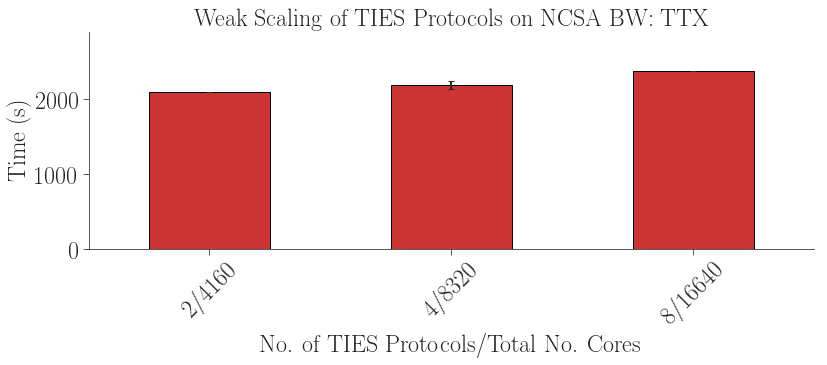

In [17]:
fig, ax = fig_setup(figsize=(13,4))

# Plot means and std bars
# sws['TTC'].reset_index().plot.bar(
#     x='nunit', y='mean', yerr='std',
#     position=1.5, width=0.25, color=tableau20[1], ax=ax, rot=45,
#     legend=False)

# sws['TTQ'].reset_index().plot.bar(
#     x='nunit', y='mean', yerr='std',
#     position=0.5, width=0.25, color=tableau20[3], ax=ax, rot=45,
#     legend=False)

ax = sws['TTX'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std', 
    width=0.5, color=tableau20[6], ax=ax, rot=45, # position=-0.5, secondary_y=True,
    title='Weak Scaling of TIES Protocols on NCSA BW: TTX',
    legend=False)


ax.set_xlabel('No. of TIES Protocols/Total No. Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0,2900)
ax.set_xlim(-0.5)


plt.savefig('figures/ties_NCSA_BW_weak_scaling.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/ties_NCSA_BW_weak_scaling.png')

In [29]:
# ------------------------------------------------------------------------------
#
# absolute utilization: number of core hours per activity
# relative utilization: percentage of total pilot core hours
#
ABSOLUTE = False


# ------------------------------------------------------------------------------
#
# pilot and unit activities: core hours are derived by multiplying the
# respective time durations with pilot size / unit size.  The 'idle' utilization
# and the 'agent' utilization are derived separately.
#
# Note that durations should add up to the `x_total` generations to ensure
# accounting for the complete unit/pilot utilization.
#
PILOT_DURATIONS = {
        'p_total'     : [{STATE: None,            EVENT: 'bootstrap_1_start'},
                         {STATE: None,            EVENT: 'bootstrap_1_stop' }],

        'p_boot'      : [{STATE: None,            EVENT: 'bootstrap_1_start'},
                         {STATE: None,            EVENT: 'sync_rel'         }],
#         'p_setup_1'   : [{STATE: None,            EVENT: 'sync_rel'         },
#                          {STATE: None,            EVENT: 'orte_dvm_start'   }],
#         'p_orte'      : [{STATE: None,            EVENT: 'orte_dvm_start'   },
#                          {STATE: None,            EVENT: 'orte_dvm_ok'      }],
#         'p_setup_2'   : [{STATE: None,            EVENT: 'orte_dvm_ok'      },
#                          {STATE: PMGR_ACTIVE,     EVENT: 'state'            }],
        'p_uexec'     : [{STATE: PMGR_ACTIVE,     EVENT: 'state'            },
                         {STATE: None,            EVENT: 'cmd'              }],
        'p_term'      : [{STATE: None,            EVENT: 'cmd'              },
                         {STATE: None,            EVENT: 'bootstrap_1_stop' }]}

UNIT_DURATIONS = {
        'u_total'     : [{STATE: None,            EVENT: 'schedule_ok'      },
                         {STATE: None,            EVENT: 'unschedule_stop'  }],

        'u_equeue'    : [{STATE: None,            EVENT: 'schedule_ok'      },
                         {STATE: AGENT_EXECUTING, EVENT: 'state'            }],
        'u_eprep'     : [{STATE: AGENT_EXECUTING, EVENT: 'state'            },
                         {STATE: None,            EVENT: 'exec_start'       }],
        'u_exec_rp'   : [{STATE: None,            EVENT: 'exec_start'       },
                         {STATE: None,            EVENT: 'cu_start'         }],
        'u_exec_cu'   : [{STATE: None,            EVENT: 'cu_start'         },
                         {STATE: None,            EVENT: 'cu_exec_start'    }]}
        #'u_exec_orte' : [{STATE: None,            EVENT: 'cu_exec_start'    },
#                          {STATE: None,            EVENT: 'app_start'        }],
        #'u_exec_app'  : [{STATE: None,            EVENT: 'app_start'        },
#                          {STATE: None,            EVENT: 'app_stop'         }],
        #'u_unschedule': [{STATE: None,            EVENT: 'app_stop'         },
#                          {STATE: None,            EVENT: 'unschedule_stop'  }]}

DERIVED_DURATIONS = ['p_agent', 'p_idle', 'p_setup']

TRANSLATE_KEYS    = {
                     'p_agent'     : '* agent nodes',
                     'p_boot'      : '* pilot bootstrap',
                     #'p_setup'     : '* pilot setup',
                     #'p_orte'      : '* orte  setup',
                     'p_term'      : '* pilot termination',
                     'p_idle'      : '* pilot idle',

                     'u_equeue'    : 'SchedulerQueing CU',
                     'u_eprep'     : '* CU preparation',
                     'u_exec_rp'   : 'Executor Spawning CU',
                     'u_exec_cu'   : 'OS Spawning CU',
                     #'u_exec_orte' : '* CU execution (ORTE)',
                     #'u_exec_app'  : 'Executable Executing',
                     #'u_unschedule': '? Scheduler Unscheduling',
    
                     'rp_overhead' : 'RP Overhead', 
                     'rp_busy'     : 'Workload Execution',
                     'rp_idle'     : 'RP Idle',
#                      'rp_orte'     : 'RP ORTE', 
                     'rp_scheduler': 'RP Scheduler'
                    }

  # # Durations sub-component level
  # df['Scheduler Scheduling']   = df['Scheduler Stops Schedule']   - df['Scheduler Starts Schedule']
  # df['Scheduler Queuing CU']   = df['Executor Starts']            - df['Scheduler Queues CU']
  # df['Executor Starting']      = df['Executor Starts Mkdir']      - df['Executor Starts']
  # df['Executor Making Dir']    = df['Executor Stops Mkdir']       - df['Executor Starts Mkdir']
  # df['Executor Spawning CU']   = df['OS Accepts Spawned CU']      - df['Executor Spawns CU']
  # df['OS Spawning CU']         = df['OS Spawns CU']               - df['OS Accepts Spawned CU']
  # df['CU Changing Dir']        = df['CU Changes Dir']             - df['OS Spawns CU']
  # df['CU Pre-executing']       = df['CU Stops Pre-execute']       - df['CU Starts Pre-execute']
  # df['CU Spawning Executable'] = df['Executable Starts']          - df['CU Spawns Executable']
  # df['Executable Executing']   = df['Executable Stops']           - df['Executable Starts']
  # df['CU Post-executing']      = df['CU Stops Post-execute']      - df['CU Starts Post-execute']
  # df['Executor Stopping']      = df['Executor Stops']             - df['CU Stops Post-execute']
  # df['Scheduler Unscheduling'] = df['Scheduler Stops Unschedule'] - df['Scheduler Starts Unschedule']


# there must be a better way to do this...
ORDERED_KEYS      = [
                     'p_boot',
                     #'p_setup',
                     #'p_orte',
                     'u_equeue',
                     'u_eprep',
                     'u_exec_rp',
                     'u_exec_cu',
                     #'u_exec_orte',
                     #'u_exec_app',
                     #'u_unschedule',
                     'p_idle',
                     'p_term',
                     'p_agent',
                     ]


(-0.5, 2.5)

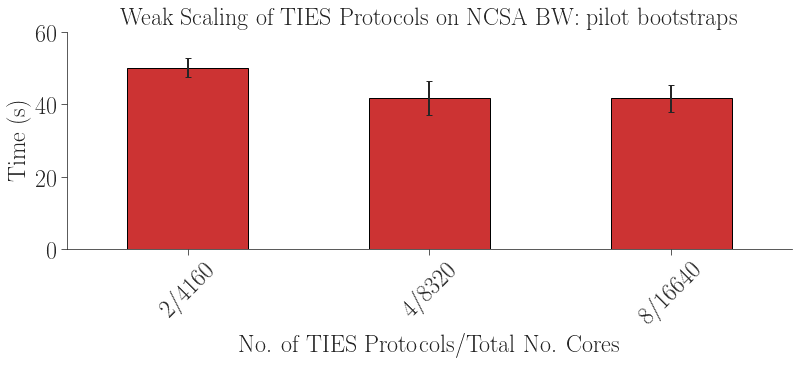

In [16]:
fig, ax = fig_setup(figsize=(13,4))

# Plot means and std bars
# sws['TTC'].reset_index().plot.bar(
#     x='nunit', y='mean', yerr='std',
#     position=1.5, width=0.25, color=tableau20[1], ax=ax, rot=45,
#     legend=False)

# sws['TTQ'].reset_index().plot.bar(
#     x='nunit', y='mean', yerr='std',
#     position=0.5, width=0.25, color=tableau20[3], ax=ax, rot=45,
#     legend=False)

ax = pws['p_bootstraps'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std', 
    width=0.5, color=tableau20[6], ax=ax, rot=45, # position=-0.5, secondary_y=True,
    title='Weak Scaling of TIES Protocols on NCSA BW: pilot bootstraps',
    legend=False)


ax.set_xlabel('No. of TIES Protocols/Total No. Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0,60)
ax.set_xlim(-0.5)


In [48]:
SUM_KEYS_RP_OVERHEAD = {'rp_overhead'  : ['p_bootstrap','p_term', 'u_equeue', 'u_eprep', 'u_exec_rp', 'u_exec_cu'] 

             }


# Strong Scaling Results on Blue Waters

In [11]:
ssc = ssc_sessions[
    ['ncore','TTC','P_LRMS_QUEUING','U_AGENT_QUEUING','U_AGENT_SCHEDULING','U_AGENT_QUEUING_EXEC','U_AGENT_EXECUTING']
        ].groupby(['ncore']).aggregate(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std']})

ssc.rename({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
ssc.rename({'U_AGENT_QUEUING'     :'Agent queueing'}, axis='columns', inplace=True)
ssc.rename({'U_AGENT_SCHEDULING'  :'Agent scheduling'}, axis='columns', inplace=True)
ssc.rename({'U_AGENT_QUEUING_EXEC':'Agent queueing execution'}, axis='columns', inplace=True)
ssc.rename({'U_AGENT_EXECUTING'   :'TTX'}, axis='columns', inplace=True)
ssc.rename(index={i: '%s/%s' % (ssc_sessions[ssc_sessions.ncore == i].nunit[0]/(65*4), i) for i in ssc.index.get_values()}, 
           inplace=True)
ssc

TTQ                Agent queueing           Agent queueing execution                    TTX                       TTC                Agent scheduling           
                mean            std           mean       std                     mean        std        mean         std          mean            std             mean        std
ncore                                                                                                                                                                            
8/4160    54615.3224   57418.104988       4.026451  0.358574                64.620897  26.219948  8400.71615  184.511100   63118.33085   57602.061858      6159.911001  22.314310
8/8320   187590.7961  198391.997549      11.763355  9.516458               176.523704  80.578209  4357.21100   78.303591  192091.78405  198418.014765      2118.040947  49.170861
8/16640    5322.4127    4926.340537      10.942751  0.193111               133.541199   3.950323  2372.45005    0.624446    7956.50255    5061.335919        37.274151   0.453322

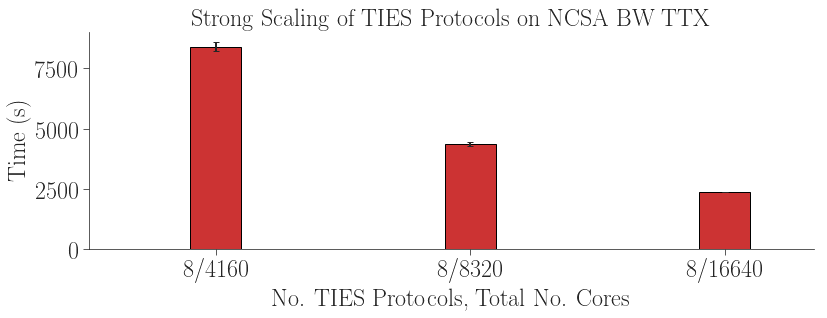

In [13]:
# fig = plt.figure(figsize=(13,4))
# ax = fig.add_subplot(111)
fig, ax = fig_setup(figsize=(13,4))

# Plot means and std bars
# ssc['TTC'].reset_index().plot.bar(
#     x='ncore', y='mean', yerr='std',
#     position=1.5, width=0.1, color=tableau20[1], ax=ax, rot=0,
#     legend=False)

# ssc['TTQ'].reset_index().plot.bar(
#     x='ncore', y='mean', yerr='std',
#     position=0.5, width=0.1, color=tableau20[3], ax=ax, rot=0,
#     legend=False)

# ax1 = ssc['TTX'].reset_index().plot.bar(
ax = ssc['TTX'].reset_index().plot.bar(
    x='ncore', y='mean', yerr='std', 
    # position=-0.5, 
    width=0.2, color=tableau20[6], ax=ax, rot=0,
    title='Strong Scaling of TIES Protocols on NCSA BW TTX',
    # secondary_y=True, 
    legend=False)



ax.set_xlabel('No. TIES Protocols, Total No. Cores')
#ax.title=('Weak Scaling of TIES Protocol Instances')
ax.set_ylabel('Time (s)')
ax.set_ylim(0)
ax.set_xlim(-0.5)

# Add common legend with f* proxy artists (https://matplotlib.org/users/legend_guide.html)
# fig.legend((# mpl.patches.Patch(facecolor=tableau20[1]), 
#             # mpl.patches.Patch(facecolor=tableau20[3]), 
#             mpl.patches.Patch(facecolor=tableau20[6]),
#             mpl.lines.Line2D([], [], color='black', linestyle='dashed')),
#            (# 'TTC', 'TTQ', 'TTX (right)', 'Mean Ideal TTX (right)'), 
#             'TTX', 'Mean Ideal TTX'),
#            'upper right',
#            # ncol=2,
#            columnspacing=0.75,
#            handletextpad=0.3,
#            bbox_to_anchor=(0.9, 1))

plt.savefig('figures/ties_NCSA_BW_strong_scaling.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/ties_NCSA_BW_strong_scaling.png')